# Import libraries

In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers

# Download [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

37 clases de perros y gatos con aproximadamente 200 imágenes por clase. 7393 imágenes en total.

### 1) Download images

In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -O - | tar -xz

--2021-09-22 13:01:32--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
SSL_INIT
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Conectando con www.robots.ox.ac.uk (www.robots.ox.ac.uk)[129.67.94.2]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 791918971 (755M) [application/x-gzip]
Grabando a: «STDOUT»

-                   100%[===================>] 755,23M  7,89MB/s    en 85s     

2021-09-22 13:02:57 (8,92 MB/s) - escritos a stdout [791918971/791918971]



In [2]:
!ls images | wc -l

7393


### 2) Download labels

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -O - | tar -xz

--2021-09-22 13:03:39--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
SSL_INIT
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Conectando con www.robots.ox.ac.uk (www.robots.ox.ac.uk)[129.67.94.2]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 19173078 (18M) [application/x-gzip]
Grabando a: «STDOUT»

-                   100%[===================>]  18,28M  5,71MB/s    en 3,5s    

2021-09-22 13:03:43 (5,28 MB/s) - escritos a stdout [19173078/19173078]



In [9]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


# Create pandas Dataframe

In [2]:
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog

train = pd.read_csv("annotations/trainval.txt", sep=' ', names=["Imagen", "RazaPG", "Animal", "Raza"])
test  = pd.read_csv("annotations/test.txt", sep=' ', names=["Imagen", "RazaPG", "Animal", "Raza"])

train["Animal"].replace({1: "Gato", 2: "Perro"}, inplace=True)
test["Animal"].replace({1: "Gato", 2: "Perro"}, inplace=True)

train["Raza"] = train.Imagen.str.replace('\d+', '', regex=True).str[:-1]
test["Raza"]  = test.Imagen.str.replace('\d+', '', regex=True).str[:-1]

train["Imagen"] = train.Imagen + ".jpg"
test["Imagen"]  = test.Imagen + ".jpg"

train.drop(columns=['RazaPG'], inplace=True)
test.drop(columns=['RazaPG'], inplace=True)

print("Train:", len(train), "Test:", len(test))
train.sample(10)

Train: 3680 Test: 3669


,Imagen,Animal,Raza
47,Abyssinian_143.jpg,Gato,Abyssinian
415,boxer_115.jpg,Perro,boxer
1221,pomeranian_123.jpg,Perro,pomeranian
3595,wheaten_terrier_15.jpg,Perro,wheaten_terrier
3162,Ragdoll_185.jpg,Gato,Ragdoll
1749,wheaten_terrier_103.jpg,Perro,wheaten_terrier
2805,leonberger_164.jpg,Perro,leonberger
3376,scottish_terrier_187.jpg,Perro,scottish_terrier
2843,Maine_Coon_163.jpg,Gato,Maine_Coon
1642,Siamese_153.jpg,Gato,Siamese


# Usar solo los perros

In [3]:
ANIMAL = "Perro"

train = train[train.Animal == ANIMAL]
test  = test[test.Animal == ANIMAL]

NUM_RAZAS = train.Raza.nunique()

print("Hay",NUM_RAZAS,"razas distintas de",ANIMAL)

Hay 25 razas distintas de Perro


In [4]:
train.Raza.value_counts()

american_bulldog              100
american_pit_bull_terrier     100
wheaten_terrier               100
staffordshire_bull_terrier    100
shiba_inu                     100
scottish_terrier              100
samoyed                       100
saint_bernard                 100
pug                           100
pomeranian                    100
miniature_pinscher            100
leonberger                    100
keeshond                      100
japanese_chin                 100
havanese                      100
great_pyrenees                100
german_shorthaired            100
english_setter                100
chihuahua                     100
boxer                         100
beagle                        100
basset_hound                  100
yorkshire_terrier             100
newfoundland                   96
english_cocker_spaniel         96
Name: Raza, dtype: int64

# Keras dataset

In [5]:
datagen = ImageDataGenerator(rescale=1./255.)

IMG_SIZE = 120

train_ds = datagen.flow_from_dataframe(dataframe=train,
                                                 directory="./images",
                                                 x_col='Imagen',
                                                 y_col="Raza",
                                                 batch_size=32,
                                                 seed=42,
                                                 shuffle=True,
                                                 target_size=(IMG_SIZE,IMG_SIZE))
                                                  
test_ds = datagen.flow_from_dataframe(dataframe=test,
                                              directory="./images",
                                              x_col='Imagen',
                                              y_col="Raza",
                                              batch_size=1,
                                              seed=42,
                                              shuffle=False,
                                              target_size=(IMG_SIZE,IMG_SIZE))

Found 2492 validated image filenames belonging to 25 classes.
Found 2486 validated image filenames belonging to 25 classes.


# Create model

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_RAZAS, activation='sigmoid'))
model.compile(optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [8]:
model.fit(x=train_ds,
          validation_data=test_ds,
          epochs=10 # callbacks=callbacks
)

2021-09-22 14:40:36.181914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-09-22 14:40:36.942470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


78/78 [==============================] - 12s 135ms/step - loss: 0.1947 - accuracy: 0.0393 - val_loss: 0.1766 - val_accuracy: 0.0595
Epoch 2/10
78/78 [==============================] - 10s 127ms/step - loss: 0.1719 - accuracy: 0.0726 - val_loss: 0.1658 - val_accuracy: 0.1078
Epoch 3/10
78/78 [==============================] - 10s 126ms/step - loss: 0.1598 - accuracy: 0.1220 - val_loss: 0.1583 - val_accuracy: 0.1500
Epoch 4/10
78/78 [==============================] - 10s 126ms/step - loss: 0.1450 - accuracy: 0.2223 - val_loss: 0.1558 - val_accuracy: 0.1653
Epoch 5/10
78/78 [==============================] - 10s 128ms/step - loss: 0.1269 - accuracy: 0.3559 - val_loss: 0.1610 - val_accuracy: 0.1738
Epoch 6/10
78/78 [==============================] - 10s 127ms/step - loss: 0.1029 - accuracy: 0.5000 - val_loss: 0.1764 - val_accuracy: 0.1677
Epoch 7/10
78/78 [==============================] - 10s 128ms/step - loss: 0.0749 - accuracy: 0.6786 - val_loss: 0.2038 - val_accuracy: 0.1613
Epoch 8/10

# Predict test data

<BarContainer object of 25 artists>

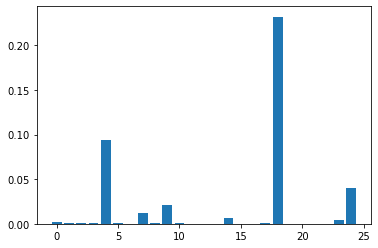

In [32]:
test_ds[0][1], 

p = model.predict(test_ds[0][0])

plt.bar(np.arange(0,25), p[0])

In [ ]:
preds_probabilities = model.predict(test_ds[])

In [9]:
preds_probabilities = model.predict(test_ds)
preds_probabilities.shape

(2486, 25)

<BarContainer object of 25 artists>

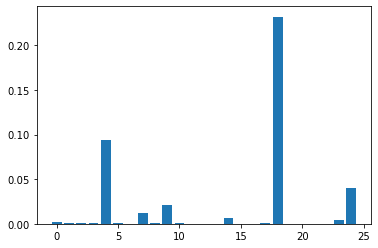

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.bar(np.arange(0,25), preds_probabilities[0])

In [10]:
preds = preds_probabilities.argmax(axis=1)
preds.shape

(2486,)

In [16]:
preds

array([18,  9, 16, ..., 14,  7, 15])

In [34]:
#train_ds.class_indices

In [39]:
( preds == np.array(test_ds.labels) ).sum() / len(preds)

0.16733708769107

In [13]:
reals = test.Raza # test_ds.labels
reals

98       american_bulldog
99       american_bulldog
100      american_bulldog
101      american_bulldog
102      american_bulldog
              ...        
3664    yorkshire_terrier
3665    yorkshire_terrier
3666    yorkshire_terrier
3667    yorkshire_terrier
3668    yorkshire_terrier
Name: Raza, Length: 2486, dtype: object

In [17]:
preds.argmax(axis=1).shape

(2486,)